[參考](https://huggingface.co/learn/nlp-course/zh-TW/chapter5/1?fw=pt)

# 本章簡介

在[第三章](https://huggingface.co/course/chapter3)第一次體驗了 🤗Datasets 庫，並發現在微調模型時有三個主要步驟：

從 Hugging Face Hub 加載一個數據集。
使用 Dataset.map() 對數據進行預處理。
載入和計算指標(特徵)。
但這只是🤗 Datasets的表面功能而已！在本章中，我們將深入瞭解這個庫。在此過程中，我們將找到以下問題的答案：

*   當數據集不在 hub 上時，您該怎麼做？
*   如何對數據集進行切片？（如果你真正的特別需要使用pandas的時候該怎麼辦？）
*   當你的數據集很大，會撐爆你筆記本電腦的RAM時，你會怎麼做？
*   「內存映射」和 Apache Arrow 到底是什麼？
*   如何創建自己的數據集並將其推送到中心？

您在這裡學到的技術將為您在[第6章](https://huggingface.co/course/chapter6)和[第7章](https://huggingface.co/course/chapter7)中的高級標記化和微調任務做好準備——所以，喝杯咖啡，讓我們開始吧!

## 如果我的數據集不在 Hub 上怎麼辦？

你知道如何使用[Hugging Face Hub](https://huggingface.co/datasets)下載數據集, 但你經常會發現自己正在處理存儲在筆記本電腦或遠程服務器上的數據。在本節中，我們將向您展示如何使用 🤗 Datasets來加載 Hugging Face Hub 上不可用的數據集。

In [1]:
!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-test.json.gz

--2024-01-11 06:07:10--  https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/crux82/squad-it/master/SQuAD_it-train.json.gz [following]
--2024-01-11 06:07:11--  https://raw.githubusercontent.com/crux82/squad-it/master/SQuAD_it-train.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7725286 (7.4M) [application/octet-stream]
Saving to: ‘SQuAD_it-train.json.gz’

SQuAD_it-train.json 100%[===================>]   7.37M  --.-KB/s    in 0.07s   

2024-01-11 06:07:12 (104 MB/s) - ‘SQuAD_it-train.json.gz’ saved [7725286/7725286]

--2024

這將下載兩個名為SQuAD_it-train.json.gz 和 SQuAD_it-test.json.gz的壓縮文件, 我們可以用Linux的解壓命令 gzip:

In [2]:
!gzip -dkv SQuAD_it-*.json.gz

SQuAD_it-test.json.gz:	 87.5% -- created SQuAD_it-test.json
SQuAD_it-train.json.gz:	 82.3% -- created SQuAD_it-train.json


In [4]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00


使用load_dataset()函數來加載JSON文件, 我們只需要知道我們是在處理普通的 JSON(類似於嵌套字典)還是 JSON 行(行分隔的 JSON)。像許多問答數據集一樣, SQuAD-it 使用嵌套格式,所有文本都存儲在 data文件中。這意味著我們可以通過指定參數field來加載數據集,如下所示:

In [5]:
from datasets import load_dataset

squad_it_dataset = load_dataset("json", data_files="SQuAD_it-train.json", field="data")

Generating train split: 0 examples [00:00, ? examples/s]

默認情況下, 加載本地文件會創建一個帶有train的DatasetDict 對象。 我們可以通過 squad_it_dataset查看:

In [6]:
squad_it_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
})

這向我們顯示了與訓練集相關聯的行數和列名。我們可以通過索引到 train 查看示例，如下所示:

In [7]:
squad_it_dataset["train"][0]

{'title': 'Terremoto del Sichuan del 2008',
 'paragraphs': [{'context': "Il terremoto del Sichuan del 2008 o il terremoto del Gran Sichuan, misurato a 8.0 Ms e 7.9 Mw, e si è verificato alle 02:28:01 PM China Standard Time all' epicentro (06:28:01 UTC) il 12 maggio nella provincia del Sichuan, ha ucciso 69.197 persone e lasciato 18.222 dispersi.",
   'qas': [{'answers': [{'answer_start': 29, 'text': '2008'}],
     'id': '56cdca7862d2951400fa6826',
     'question': 'In quale anno si è verificato il terremoto nel Sichuan?'},
    {'answers': [{'answer_start': 232, 'text': '69.197'}],
     'id': '56cdca7862d2951400fa6828',
     'question': 'Quante persone sono state uccise come risultato?'},
    {'answers': [{'answer_start': 29, 'text': '2008'}],
     'id': '56d4f9902ccc5a1400d833c0',
     'question': 'Quale anno ha avuto luogo il terremoto del Sichuan?'},
    {'answers': [{'answer_start': 78, 'text': '8.0 Ms e 7.9 Mw'}],
     'id': '56d4f9902ccc5a1400d833c1',
     'question': 'Che cosa ha

很好, 我們已經加載了我們的第一個本地數據集! 但是, 雖然這對訓練集有效, 但是我們真正想要的是包括 train 和 test 的 DatasetDict 對象。這樣的話就可以使用 Dataset.map() 函數同時處理訓練集和測試集。 為此, 我們提供參數data_files的字典,將每個分割名稱映射到與該分割相關聯的文件：

In [8]:
data_files = {"train": "SQuAD_it-train.json", "test": "SQuAD_it-test.json"}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")
squad_it_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

這正是我們想要的。現在, 我們可以應用各種預處理技術來清理數據、標記評論等。

load_dataset()函數的data_files參數非常靈活並且可以是單個文件路徑、文件路徑列表或將分割後的名稱映射到文件路徑的字典。您還可以根據Unix shell使用的規則對與指定模式匹配的文件進行全局定位（例如，您可以通過設置’data_files=“*.JSON”‘將目錄中的所有JSON文件作為單個拆分進行全局定位）。有關更多詳細信息，請參閱🤗Datasets 文檔。

Datasets實際上支持輸入文件的自動解壓,所以我們可以跳過使用gzip,直接設置 data_files參數傳遞壓縮文件:

In [9]:
data_files = {"train": "SQuAD_it-train.json.gz", "test": "SQuAD_it-test.json.gz"}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

如果您不想手動解壓縮許多 GZIP 文件，這會很有用。自動解壓也適用於其他常見格式,如 ZIP 和 TAR,因此您只需將 data_files 設置為壓縮文件所在的路徑,你就可以開始了!

現在你知道如何在筆記本電腦或臺式機上加載本地文件，讓我們來看看加載遠程文件。

## 加載遠程數據集
如果你在公司擔任數據研究員或編碼員,那麼你要分析的數據集很有可能存儲在某個遠程服務器上。幸運的是,加載遠程文件就像加載本地文件一樣簡單!我們沒有提供本地文件的路徑, 而是將load_dataset()的data_files參數指向存儲遠程文件的一個或多個URL。例如, 對於託管在 GitHub 上的 SQuAD-it 數據集, 我們可以將 data_files 指向 SQuAD_it-*.json.gz 的網址,如下所示:

In [10]:
url = "https://github.com/crux82/squad-it/raw/master/"
data_files = {
    "train": url + "SQuAD_it-train.json.gz",
    "test": url + "SQuAD_it-test.json.gz",
}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

這將返回和上面的本地例子相同的 DatasetDict 對象, 但省去了我們手動下載和解壓 SQuAD_it-*.json.gz 文件的步驟。這是我們對加載未託管在Hugging Face Hub的數據集的各種方法的總結。既然我們已經有了一個可以使用的數據集,讓我們開始大展身手吧！

# 是時候來學一下切片了

大多數情況下，您使用的數據都需根據模型所要求的輸入進行清洗。在本節中，我們將探索 🤗 Datasets 提供的用於數據集清洗的各種功能。

## 切片與切分我們的數據
與 Pandas 類似，🤗 Datasets 提供了幾個函數來操作 Dataset 和 DatasetDict 對象。我們在第三章已經遇到了 Dataset.map() 方法，在本節中，我們將探索我們可以使用的其他功能。

對於這個例子，我們將使用託管在[加州大學歐文分校機器學習存儲庫](https://archive.ics.uci.edu/ml/index.php)的[藥物審查數據集](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29)，其中包含患者對各種藥物的評論，以及正在治療的病情和患者滿意度的 10 星評級。

首先我們需要下載並提取數據，這可以通過 wget 和 unzip 命令：

In [11]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

--2024-01-11 06:11:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip        [    <=>             ]  41.00M  24.8MB/s    in 1.7s    

2024-01-11 06:11:52 (24.8 MB/s) - ‘drugsCom_raw.zip’ saved [42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


由於 TSV 只是使用製表符而不是逗號作為分隔符的 CSV 變體，我們可以使用加載csv文件的load_dataset()函數並指定分隔符 示例如下：

In [12]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
# \t is the tab character in Python
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

在進行任何類型的數據分析時，一個好的做法是抽取一個小的隨機樣本，以快速瞭解您正在處理的數據類型。在🤗數據集中，我們可以通過鏈接 Dataset.shuffle() 和 Dataset.select() 共同來完成抽取：

In [13]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000))
# Peek at the first few examples
drug_sample[:3]

{'Unnamed: 0': [87571, 178045, 80482],
 'drugName': ['Naproxen', 'Duloxetine', 'Mobic'],
 'condition': ['Gout, Acute', 'ibromyalgia', 'Inflammatory Conditions'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"',
  '"I have taken Cymbalta for about a year and a half for fibromyalgia pain. It is great\r\nas a pain reducer and an anti-depressant, however, the side effects outweighed \r\nany benefit I got from it. I had trouble with restlessness, being tired constantly,\r\ndizziness, dry mouth, numbness and tingling in my feet, and horrible sweating. I am\r\nbeing weaned off of it now. Went from 60 mg to 30mg and now to 15 mg. I will be\r\noff completely in about a week. The fibro pain is coming back, but I would rather deal with it than the side effects."',
  '"I have been taking Mobic for over a year with no side effects other than 

請注意，出於可以復現的目的，我們已將在Dataset.shuffle()選取了固定的隨機數種子。 Dataset.select() 需要一個可迭代的索引，所以我們已經通過了 range(1000) 從隨機打亂的數據集中選取前 1,000 個示例。從抽取的數據中，我們已經可以看到我們數據集的一些特點：

*   Unnamed: 0這列看起來很像每個患者的匿名 ID。
*   condition 這列包含有描述健康狀況的標籤。
*   評論長短不一，混合有 Python 行分隔符 (\r\n) 以及 HTML 字符代碼，如'。


讓我們看看我們如何使用 🤗 Datasets 來處理這些問題。為了驗證Unnamed: 0 列存儲的是患者 ID的猜想，我們可以使用 Dataset.unique() 函數來驗證匿名ID 的數量是否與拆分後每部分中的行數匹配：

In [14]:
for split in drug_dataset.keys():
    assert len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0"))

這似乎證實了我們的假設，所以讓我們把 Unnamed: 0 列重命名為患者的id。我們可以使用 DatasetDict.rename_column()函數一次性重命名DatasetDict中共有的列：

In [15]:
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

接下來，讓我們使用 Dataset.map()標準化所有 condition 標籤 .正如我們在第三章中所做的那樣，我們可以定義一個簡單的函數，可以將該函數應用於drug_dataset 拆分後每部分的所有行：

In [16]:
def lowercase_condition(example):
    return {"condition": example["condition"].lower()}


drug_dataset.map(lowercase_condition)

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

AttributeError: 'NoneType' object has no attribute 'lower'

哦不，我們的map功能遇到了問題！從錯誤中我們可以推斷出 condition 列存在 None , 不能轉換為小寫，因為它們不是字符串。讓我們使用 Dataset.filter() 刪除這些行 ，其工作方式類似於 Dataset.map() 。例如：

In [17]:
def filter_nones(x):
    return x["condition"] is not None

然後運行 drug_dataset.filter(filter_nones) ，我們可以在一行中使用lambda 函數.在 Python 中，lambda 函數是您無需明確命名即可使用的微函數（匿名函數）。它們一般採用如下形式：

### lambda \<arguments\> : \<expression\>

其中lambda 是 Python 的特殊關鍵字, arguments 是以逗號進行分隔的函數輸入的列表/集合， expression 代表您希望執行的操作。例如，我們可以定義一個簡單的 lambda 函數來對一個數字進行平方，如下所示：

lambda x : x * x

我們需要將要輸入給這個函數值括在括號中：

In [18]:
(lambda x: x * x)(3)

9

類似地，我們可以通過用逗號分隔多個參數來定義 lambda 函數。例如，我們可以按如下方式計算三角形的面積：

In [19]:
(lambda base, height: 0.5 * base * height)(4, 8)

16.0

當您想定義小型、一次性使用的函數時，Lambda 函數非常方便（有關它們的更多信息，我們建議閱讀安德烈·布爾高寫的真正的Python教程）。在🤗 Datasets 中，我們可以使用 lambda 函數來定義簡單的映射和過濾操作，所以讓我們使用這個技巧來消除我們數據集中的 None 條目：

In [20]:
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

當 None 條目已刪除，我們可以標準化我們的 condition 列：

In [21]:
drug_dataset = drug_dataset.map(lowercase_condition)
# Check that lowercasing worked
drug_dataset["train"]["condition"][:3]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

['left ventricular dysfunction', 'adhd', 'birth control']

有用！現在我們已經清理了標籤，讓我們來看看清洗後的評論文本。

## Creating new columns

每當您處理客戶評論時，一個好的做法是檢查每個評論中的字數。評論可能只是一個詞，比如“太棒了！”或包含數千字的完整文章，根據實際的情況，您需要以不同的方式處理這些極端情況。為了計算每條評論中的單詞數，我們將使用基於空格分割每個文本的粗略方法。

讓我們定義一個簡單的函數來計算每條評論中的單詞數：

In [22]:
def compute_review_length(example):
    return {"review_length": len(example["review"].split())}

與我們的 lowercase_condition() 函數不同，compute_review_length() 返回一個字典，其鍵與數據集中的列名之一不對應。 在這種情況下，當 compute_review_length() 傳遞給 Dataset.map() 時，它將應用於數據集中的所有行以創建新的 review_length 列：

In [23]:
drug_dataset = drug_dataset.map(compute_review_length)
# Inspect the first training example
drug_dataset["train"][0]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

{'patient_id': 206461,
 'drugName': 'Valsartan',
 'condition': 'left ventricular dysfunction',
 'review': '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'rating': 9.0,
 'date': 'May 20, 2012',
 'usefulCount': 27,
 'review_length': 17}

正如預期的那樣，我們可以看到一個 review_length 列已添加到我們的訓練集中。我們可以使用 Dataset.sort()對這個新列進行排序，然後查看極端長度的評論的樣子：

In [24]:
drug_dataset["train"].sort("review_length")[:3]

{'patient_id': [111469, 13653, 53602],
 'drugName': ['Ledipasvir / sofosbuvir',
  'Amphetamine / dextroamphetamine',
  'Alesse'],
 'condition': ['hepatitis c', 'adhd', 'birth control'],
 'review': ['"Headache"', '"Great"', '"Awesome"'],
 'rating': [10.0, 10.0, 10.0],
 'date': ['February 3, 2015', 'October 20, 2009', 'November 23, 2015'],
 'usefulCount': [41, 3, 0],
 'review_length': [1, 1, 1]}

正如我們所猜想的那樣，一些評論只包含一個詞，雖然這對於情感分析來說可能沒問題，但如果我們想要預測病情，這些評論可能並不適合。

讓我們使用 Dataset.filter() 功能來刪除包含少於 30 個單詞的評論。與我們對 condition 列的處理相似，我們可以通過選取評論的長度高於此閾值來過濾掉非常短的評論：

In [25]:
drug_dataset = drug_dataset.filter(lambda x: x["review_length"] > 30)
print(drug_dataset.num_rows)

Filter:   0%|          | 0/160398 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53471 [00:00<?, ? examples/s]

{'train': 138514, 'test': 46108}


如您所見，這已經從我們的原始訓練和測試集中刪除了大約 15% 的評論。

我們需要處理的最後一件事是評論中是否存在 HTML 字符代碼。我們可以使用 Python 的html模塊取消這些字符的轉義，如下所示：

In [26]:
import html

text = "I&#039;m a transformer called BERT"
html.unescape(text)

"I'm a transformer called BERT"

我們將使用 Dataset.map() 對我們語料庫中的所有 HTML 字符進行轉義：

In [27]:
drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

如您所見， Dataset.map() 方法對於處理數據非常有用——在示例中僅僅是淺嘗輒止就有很大的收穫！

### map() 方法的超級加速

Dataset.map() 方法有一個 batched 參數，如果設置為 True , map 函數將會分批執行所需要進行的操作（批量大小是可配置的，但默認為 1,000）。例如，之前對所有 HTML 進行轉義的 map 函數運行需要一些時間（您可以從進度條中讀取所用時間）。我們可以通過使用列表推導同時處理多個元素來加快速度。

當您在使用 Dataset.map()函數時指定 batched=True。該函數會接收一個包含數據集字段的字典，每個值都是一個列表，而不僅僅是單個值。Dataset.map() 的返回值應該是相同的：一個包含我們想要更新或添加到數據集中的字段的字典，字典的鍵是要添加的字段，字典的值是結果的列表。例如，這是使用 batched=True對所有 HTML 字符進行轉義的方法 ：

In [28]:
new_drug_dataset = drug_dataset.map(
    lambda x: {"review": [html.unescape(o) for o in x["review"]]}, batched=True
)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

如果您在筆記本中運行此代碼，您會看到此命令的執行速度比前一個命令快得多。這不是因為我們的評論已經是處理過的——如果你重新執行上一節的指令（沒有 batched=True )，它將花費與以前相同的時間。這是因為列表推導式通常比在同一代碼中用 for 循環執行相同的代碼更快，並且我們還通過同時訪問多個元素而不是一個一個來處理來提高處理的速度。

在第六章我們將遇到的“快速”標記器，它可以快速標記大文本列表。使用 Dataset.map() 和 batched=True 是加速的關鍵。例如，要使用快速標記器標記所有藥物評論，我們可以使用這樣的函數：

In [29]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["review"], truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

正如你在[第三章](https://huggingface.co/course/chapter3)所看到的，我們原本就可以將一個或多個示例傳遞給分詞器，因此在batched=True是一個非必須的選項.讓我們藉此機會比較不同選項的性能。在筆記本中，您可以在您要測量的代碼行之前添加 %time來測試改行運行所消耗的時間：

In [30]:
%time tokenized_dataset = drug_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

CPU times: user 2min, sys: 1.04 s, total: 2min 1s
Wall time: 1min 22s


您還可以通過將整個單元格計時 %%time 在單元格的開頭。在我們執行此操作的硬件上，該指令顯示 10.8 秒（這是寫在“Wall time”之後的數字）。

以下是我們在使用和不使用批處理時使用快速和慢速分詞器獲得的結果：

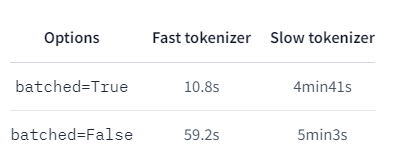

這意味著使用帶有 batched=True 選項比沒有批處理的慢選項快 30 倍——這真是太棒了！這就是為什麼AutoTokenizer 的默認設置是use_fast=True的主要原因 （以及為什麼它們被稱為“快速”）。他們能夠實現這樣的加速，因為在底層的標記化代碼是在 Rust 中執行的，Rust 是一種可以輕鬆並行化執行的語言。

並行化也是快速標記器通過批處理實現近 6 倍加速的原因：單個標記化操作是不能並行的，但是當您想同時標記大量文本時，您可以將執行拆分為多個進程，每個進程都對自己的文本負責。

Dataset.map() 也有一些自己的並行化能力。由於它們不受 Rust 的支持，因此慢速分詞器的速度趕不上快速分詞器，但它們仍然會更快一些（尤其是當您使用沒有快速版本的分詞器時）。要啟用多處理，請在Dataset.map()時使用 num_proc 參數並指定要在調用中使用的進程數 ：

In [ ]:
slow_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=False)


def slow_tokenize_function(examples):
    return slow_tokenizer(examples["review"], truncation=True)


tokenized_dataset = drug_dataset.map(slow_tokenize_function, batched=True, num_proc=8)

Map (num_proc=8):   0%|          | 0/138514 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/46108 [00:00<?, ? examples/s]

您可以對處理的時間進行一些試驗，以確定要使用的最佳進程數；在我們的例子中，8 似乎產生了最好的速度增益。以下是我們在使用和不使用多處理時所需要的時間：

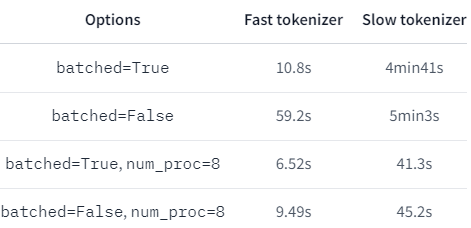

對於慢速分詞器來說，這些結果要合理得多，但快速分詞器的性能也得到了顯著提高。但是請注意，情況並非總是如此——除了 num_proc=8，我們的測試表明，使用batched=True而不帶有num_proc參數的選項處理起來更快。通常，我們不建議將 Python 多線程處理用於具有batched=True功能的快速標記器 .

將所有這些功能濃縮到一個方法中已經非常了不起，但還有更多！使用 Dataset.map() 和 batched=True 您可以更改數據集中的元素數量。當你想從一個例子中創建幾個訓練特徵時，這是非常有用的。我們將在第七章.中進行的幾個NLP任務的預處理中使用到這個功能，它非常便利。

讓我們來看看它是如何工作的！在這裡，我們將標記化我們的示例並將最大截斷長度設置128，但我們將要求標記器返回全部文本塊，而不僅僅是第一個。這可以用 return_overflowing_tokens=True ：

In [31]:
def tokenize_and_split(examples):
    return tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )

在使用Dataset.map() 正式在整個數據集上開始處理之前讓我們先在一個例子上測試一下：

In [32]:
result = tokenize_and_split(drug_dataset["train"][0])
[len(inp) for inp in result["input_ids"]]

[128, 49]

瞧！我們在訓練集中的第一個示例變成了兩個特徵，因為它被標記為超過我們指定的最大截斷長度，因此結果被截成了兩段：第一段長度為 128 ，第二段長度為 49 。現在讓我們對所有元素執行此操作數據集！

In [33]:
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

ArrowInvalid: Column 8 named input_ids expected length 1000 but got length 1463

不好了！它沒有起作用！為什麼呢？查看錯誤消息會給我們一個線索：列的長度不匹配，一列長度為 1,463，另一列長度為 1,000。1,000行的”review”給出了 1,463 行的新特徵，導致和原本的1000行數據不匹配。

問題出在我們試圖混合兩個不同大小的不同數據集： drug_dataset 列將有一定數量的元素（我們錯誤中的 1,000），但是我們正在構建tokenized_dataset 將有更多的元素（錯誤消息中的 1,463）。這不適用於 Dataset ，因此我們需要從舊數據集中刪除列或使它們的大小與新數據集中的大小相同。我們可以用 remove_columns 參數：

In [34]:
tokenized_dataset = drug_dataset.map(
    tokenize_and_split, batched=True, remove_columns=drug_dataset["train"].column_names
)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

現在這個過程沒有錯誤。我們可以通過比較長度來檢查新數據集的元素是否比原始數據集多得多：

In [35]:
len(tokenized_dataset["train"]), len(drug_dataset["train"])

(206772, 138514)

我們提到我們還可以通過使舊列與新列的大小相同來處理長度不匹配的問題。為此，我們可以使用 overflow_to_sample_mapping 字段，當我們設置return_overflowing_tokens=True .它為我們提供了特徵到它所產生的樣本的映射。使用這個，我們可以將原始數據集中的每個鍵關聯到一個合適大小的值列表中，通過遍歷所有的數據來生成新特性:

In [36]:
def tokenize_and_split(examples):
    result = tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )
    # Extract mapping between new and old indices
    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
    return result

我們可以使用Dataset.map()來進行批處理，這樣無需我們刪除舊列：

我們獲得了與以前相同數量的訓練特徵，但在這裡我們保留了所有舊字段。如果您在使用模型計算之後需要它們進行一些後處理，您可能需要使用這種方法。

您現在已經瞭解了 🤗 Datasets如何以各種方式用於預處理數據集。雖然🤗 Datasets 的處理功能會覆蓋你大部分的模型訓練需求，有時您可能需要切換到 Pandas 以使用更強大的功能，例如 DataFrame.groupby() 或用於可視化的高級 API。幸運的是，🤗 Datasets旨在與 Pandas、NumPy、PyTorch、TensorFlow 和 JAX 等庫可以相互轉換。讓我們來看看這是如何工作的。

In [37]:
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)
tokenized_dataset

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 206772
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 68876
    })
})

## `🤗 Datasets 和 DataFrames 的相互轉換

為了實現各種第三方庫之間的轉換，🤗 Datasets 提供了一個 Dataset.set_format() 功能。此功能可以通過僅更改輸出格式的，輕鬆切換到另一種格式，而不會影響底層數據格式，即 Apache Arrow。格式化會在數據本身上進行。為了演示，讓我們將數據集轉換為 Pandas：

In [38]:
drug_dataset.set_format("pandas")

現在，當我們訪問數據集的元素時，我們會得到一個 pandas.DataFrame 而不是字典：

In [39]:
drug_dataset["train"][:3]

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,95260,Guanfacine,adhd,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141
1,92703,Lybrel,birth control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134
2,138000,Ortho Evra,birth control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89


讓我們創建一個 pandas.DataFrame 來選擇 drug_dataset[train] 的所有元素：

In [40]:
train_df = drug_dataset["train"][:]

從這裡我們可以使用我們想要的所有 Pandas 功能。例如，我們可以通過花式鏈接來計算 condition類之間的分佈 ：

In [41]:
frequencies = (
    train_df["condition"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "condition", "condition": "frequency"})
)
frequencies.head()

,condition,frequency
0,birth control,27655
1,depression,8023
2,acne,5209
3,anxiety,4991
4,pain,4744


一旦我們完成了 Pandas 分析，我們總是通過使用對象 Dataset.from_pandas()方法可以創建一個新的 Dataset 如下：

In [42]:
from datasets import Dataset

freq_dataset = Dataset.from_pandas(frequencies)
freq_dataset

Dataset({
    features: ['condition', 'frequency'],
    num_rows: 819
})

我們對 🤗 Datasets中可用的各種預處理技術的介紹到此結束。在最後一部分，讓我們創建一個驗證集來準備用於訓練分類器的數據集。在此之前，我們將輸出格式 drug_dataset 從 pandas重置到 arrow ：

In [43]:
drug_dataset.reset_format()

## 創建驗證集
儘管我們有一個可以用於評估的測試集，但在開發過程中保持測試集不變並創建一個單獨的驗證集是一個很好的做法。一旦您對模型在測試集上的表現感到滿意，您就可以對驗證集進行最終的檢查。此過程有助於降低您過擬合測試集並部署在現實世界數據上失敗的模型的風險。

🤗 Datasets提供了一個基於scikit-learn的經典方法Dataset.train_test_split() .讓我們用它把我們的訓練集分成 train 和 validation （為了可以復現，我們將設置seed的值為一個常量）：

In [44]:
drug_dataset_clean = drug_dataset["train"].train_test_split(train_size=0.8, seed=42)
# Rename the default "test" split to "validation"
drug_dataset_clean["validation"] = drug_dataset_clean.pop("test")
# Add the "test" set to our `DatasetDict`
drug_dataset_clean["test"] = drug_dataset["test"]
drug_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 110811
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 27703
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46108
    })
})

太好了，我們現在已經準備好了一個數據集，可以用來訓練一些模型了！在[第五節]](/course/chapter5/5)我們將向您展示如何將數據集上傳到 Hugging Face Hub，但現在讓我們查看在本地計算機上保存數據集的幾種方法。

## 保存數據集

雖然 🤗 Datasets 會緩存每個下載的數據集和對它執行的操作，但有時你會想要將數據集保存到磁盤（例如，以防緩存被刪除）。如下表所示，🤗 Datasets 提供了三個主要功能來以不同的格式保存您的數據集：

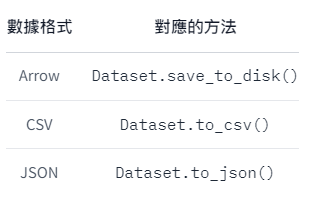

In [45]:
drug_dataset_clean.save_to_disk("drug-reviews")

Saving the dataset (0/1 shards):   0%|          | 0/110811 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/27703 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/46108 [00:00<?, ? examples/s]

這將創建一個具有以下結構的目錄：

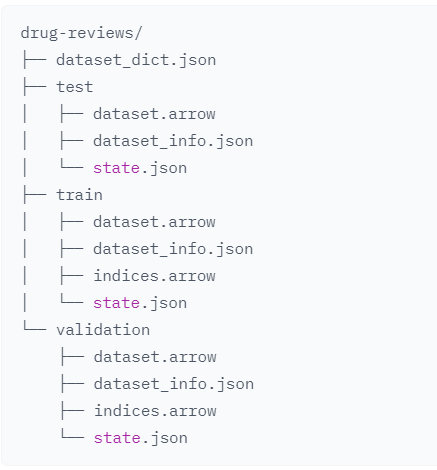

在那裡我們可以看到每個部分.arrow表，以及一些元數據數據集信息.json和狀態文件保存在一起.您可以將 Arrow 格式視為一個精美的列和行的表格，它針對構建處理和傳輸大型數據集的高性能應用程序進行了優化。

保存數據集後，我們可以使用 load_from_disk() 功能從磁盤讀取數據如下：

In [47]:
from datasets import load_from_disk

drug_dataset_reloaded = load_from_disk("drug-reviews")
drug_dataset_reloaded

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 110811
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 27703
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46108
    })
})

對於 CSV 和 JSON 格式，我們必須將每個部分存儲為單獨的文件。一種方法是迭代DatasetDict中的鍵和值 ：

In [48]:
for split, dataset in drug_dataset_clean.items():
    dataset.to_json(f"drug-reviews-{split}.jsonl")

Creating json from Arrow format:   0%|          | 0/111 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/28 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/47 [00:00<?, ?ba/s]

這將保存每個拆分都是JSON的標準格式，其中數據集中的每一行都存儲為一行 JSON。這是第一個示例：

In [49]:
!head -n 1 drug-reviews-train.jsonl

{"patient_id":89879,"drugName":"Cyclosporine","condition":"keratoconjunctivitis sicca","review":"\"I have used Restasis for about a year now and have seen almost no progress.  For most of my life I've had red and bothersome eyes. After trying various eye drops, my doctor recommended Restasis.  He said it typically takes 3 to 6 months for it to really kick in but it never did kick in.  When I put the drops in it burns my eyes for the first 30 - 40 minutes.  I've talked with my doctor about this and he said it is normal but should go away after some time, but it hasn't. Every year around spring time my eyes get terrible irritated  and this year has been the same (maybe even worse than other years) even though I've been using Restasis for a year now. The only difference I notice was for the first couple weeks, but now I'm ready to move on.\"","rating":2.0,"date":"April 20, 2013","usefulCount":69,"review_length":147}


然後我們可以使用[第二節](https://huggingface.co/course/chapter5/2)學過的技術加載 JSON 文件如下：

In [50]:
data_files = {
    "train": "drug-reviews-train.jsonl",
    "validation": "drug-reviews-validation.jsonl",
    "test": "drug-reviews-test.jsonl",
}
drug_dataset_reloaded = load_dataset("json", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

這就是我們探索 🤗 Datasets 的旅程！現在我們有了一個清洗過的數據集，以下是您可以嘗試的一些想法：

使用第3章的技術來訓練一個分類器，它可以根據藥物評論預測病人的情況。
使用 Chapter 1 中的“summarization”管道生成評論摘要。
接下來，我們將看看 🤗 Datasets如何使您能夠在不撐爆筆記本電腦內存的情況下處理龐大的數據集！